# Import packages

In [19]:
import numpy as np
import seaborn as sns
import sys
sys.path.append('../')
from utilities.vmd_post_func import *
from scipy import signal
import control

# Functions and Class

In [20]:
class VehicleDynamics():
    def __init__(self):
        # mass properties of vehicle
        self.Me = 204 # taken from https://autotrends.org/how-much-does-car-engine-weigh/
        self.Mb = 1323
        self.Iyy = 1000
        self.Mf = 100
        self.Mr = 80
        
        # stiffness values
        self.Km = 8.5e5 # tuned according to frequency of mount 12-15 Hz.
        self.Kfs = 30e3
        self.Krs = 30e3
        self.Kft = 220e3
        self.Krt = 220e3
        
        # damping values
        self.Cm = 1380 # https://dc.uwm.edu/cgi/viewcontent.cgi?article=1349&context=etd
        self.Cfs = 3.5e3
        self.Crs = 3.5e3
        
        # CG location
        self.a = 1.076
        self.b = 1.614

def get_dynamic_matrices(vehicle_object):
    """ This function is used to compute the K, C, and M matrices of a 4 dof vehicle model.
    
    Inputs:
        vehicle_oject (object): vehicle class object that contains the vehicle inputs
    
    Returns:
        K_mat, C_mat, M_mat: K, C, and M matrices.
    """
    # call vehicle dynamic objects to obtain vehicle properties
    Me,Mb,Iyy,Mf,Mr = vehicle_object.Me,vehicle_object.Mb,vehicle_object.Iyy,vehicle_object.Mf,vehicle_object.Mr # mass of engine, body, and unsprung mass
    Km,Kfs,Krs,Kft,Krt = vehicle_object.Km,vehicle_object.Kfs,vehicle_object.Krs,vehicle_object.Kft,vehicle_object.Krt # stiffness values for the engine mount, vehicle suspension, and tire (N/m)
    Cm,Cfs,Crs = vehicle_object.Cm,vehicle_object.Cfs,vehicle_object.Crs # damping coefficient for engine mount and suspension (N-s/m)
    a,b = vehicle_object.a,vehicle_object.b # CG location (m)
    
    # create variables that will be used
    # collect K and M matrices
    K_mat = np.array([[(Kfs+Krs+Km),-(-Kfs*a+Krs*b-Km*a),-Kfs,-Krs,-Km],
                    [-(-Kfs*a+Krs*b-Km*a),Kfs*a**2+Krs*b**2+Km*a**2,-Kfs*a,Krs*b,-Km*a],
                    [-Kfs,-Kfs*a,Kfs+Kft,0,0],
                    [-Krs,b*Krs,0,Krs+Krt,0],
                    [-Km,-Km*a,0,0,Km]]) # type: ignore 
    C_mat = np.array([[(Cfs+Crs+Cm),-(-Cfs*a+Crs*b-Cm*a),-Cfs,-Crs,-Cm],# type: ignore
                    [-(-Cfs*a+Crs*b-Cm*a),Cfs*a**2+Crs*b**2+Cm*a**2,-Cfs*a,Crs*b,-Cm*a],
                    [-Cfs,-Cfs*a,Cfs,0,0],
                    [-Crs,b*Crs,0,Crs,0],
                    [-Cm,-Cm*a,0,0,Cm]])
    M_mat = np.diag((Mb,Iyy,Mf,Mr,Me))
    
    return K_mat, C_mat, M_mat

def get_ss(veh_params):
    """This function is used to compute the state-space model of a vehicle and convert it into a transfer function using MIMO.

    Args:
        veh_params (object): object containing vehicle properties.

    returns:
        [LTI]: LTI class transfer function.
    """
    K_mat, C_mat, M_mat = get_dynamic_matrices(veh_params)
    dof = K_mat.shape[0]
# define state space model:
    # state matrix (A):
    A = np.zeros((2*dof,2*dof))
    A[:dof,dof:] = np.eye(dof)
    A[dof:,:dof] = -np.linalg.inv(M_mat)@K_mat
    A[dof:,dof:] = -np.linalg.inv(M_mat)@C_mat

    # input matrix (B):
    B = np.zeros((2*dof,1))
    B[-1] = 1
    
    # output matrix (C):
    C = np.zeros((2*dof,2*dof))
    C[:dof,:dof] = np.eye(dof)
    C[dof:,:dof] = -np.linalg.inv(M_mat)@K_mat
    C[dof:,dof:] = -np.linalg.inv(M_mat)@C_mat
    
    # D matrix
    D = np.zeros((2*dof,1))
    D[-1] = 1
    
    # assemble statespace:
    ss_sys = signal.StateSpace(A, B, C, D)
    return ss_sys

def get_tf(veh_params):
    """This function is used to compute the state-space model of a vehicle and convert it into a transfer function using MIMO.

    Args:
        veh_params (object): object containing vehicle properties.

    returns:
        [LTI]: LTI class transfer function.
    """
    K_mat, C_mat, M_mat = get_dynamic_matrices(veh_params)
    dof = K_mat.shape[0]
# define state space model:
    # state matrix (A):
    A = np.zeros((2*dof,2*dof))
    A[:dof,dof:] = np.eye(dof)
    A[dof:,:dof] = -np.linalg.inv(M_mat)@K_mat
    A[dof:,dof:] = -np.linalg.inv(M_mat)@C_mat

    # input matrix (B):
    B = np.zeros((2*dof,1))
    B[-1] = 1
    
    # output matrix (C):
    C = np.zeros((2*dof,2*dof))
    C[:dof,:dof] = np.eye(dof)
    C[dof:,:dof] = -np.linalg.inv(M_mat)@K_mat
    C[dof:,dof:] = -np.linalg.inv(M_mat)@C_mat
    
    # D matrix
    D = np.zeros((2*dof,1))
    D[-1] = 1
    
    # assemble statespace:
    ss_sys = control.ss(A, B, C, D)
    return control.ss2tf(ss_sys)

# Plot format definition

In [21]:
sns.set_style({'font.family':'Times New Roman','grid.linestyle':'--','grid.color':'k','axes.facecolor':'white','axes.edgecolor':'k','axes.grid':True})
sns.set_context({'font.size':32,'grid.linewidth':1})

# Eigenfrequencies to tune engine mount stiffness

In [22]:
from scipy import linalg
veh_inputs = VehicleDynamics()
veh_inputs.Cm=0.0
veh_inputs.Km=10.5e5
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)

# calculate eigenvectors and values
wn,v = linalg.eig(K_mat,M_mat)

fn = np.sqrt(np.real(wn))/(2*np.pi)
print(fn)
print(np.around(v,1))
# print(v)

[13.48445898  0.87087552  1.51664636  8.91339923  7.96405462]
[[-0.1  0.6  0.3 -0.  -0. ]
 [-0.2  0.2 -0.8  0.  -0. ]
 [ 0.   0.1 -0.1 -0.   1. ]
 [-0.   0.   0.2  1.   0. ]
 [ 1.   0.8 -0.5  0.  -0. ]]


# Define transfer function of half-car model with engine ontop

Text(0, 0.5, 'Acceleration $\\left( \\frac{m/s^2}{N} \\right)$')

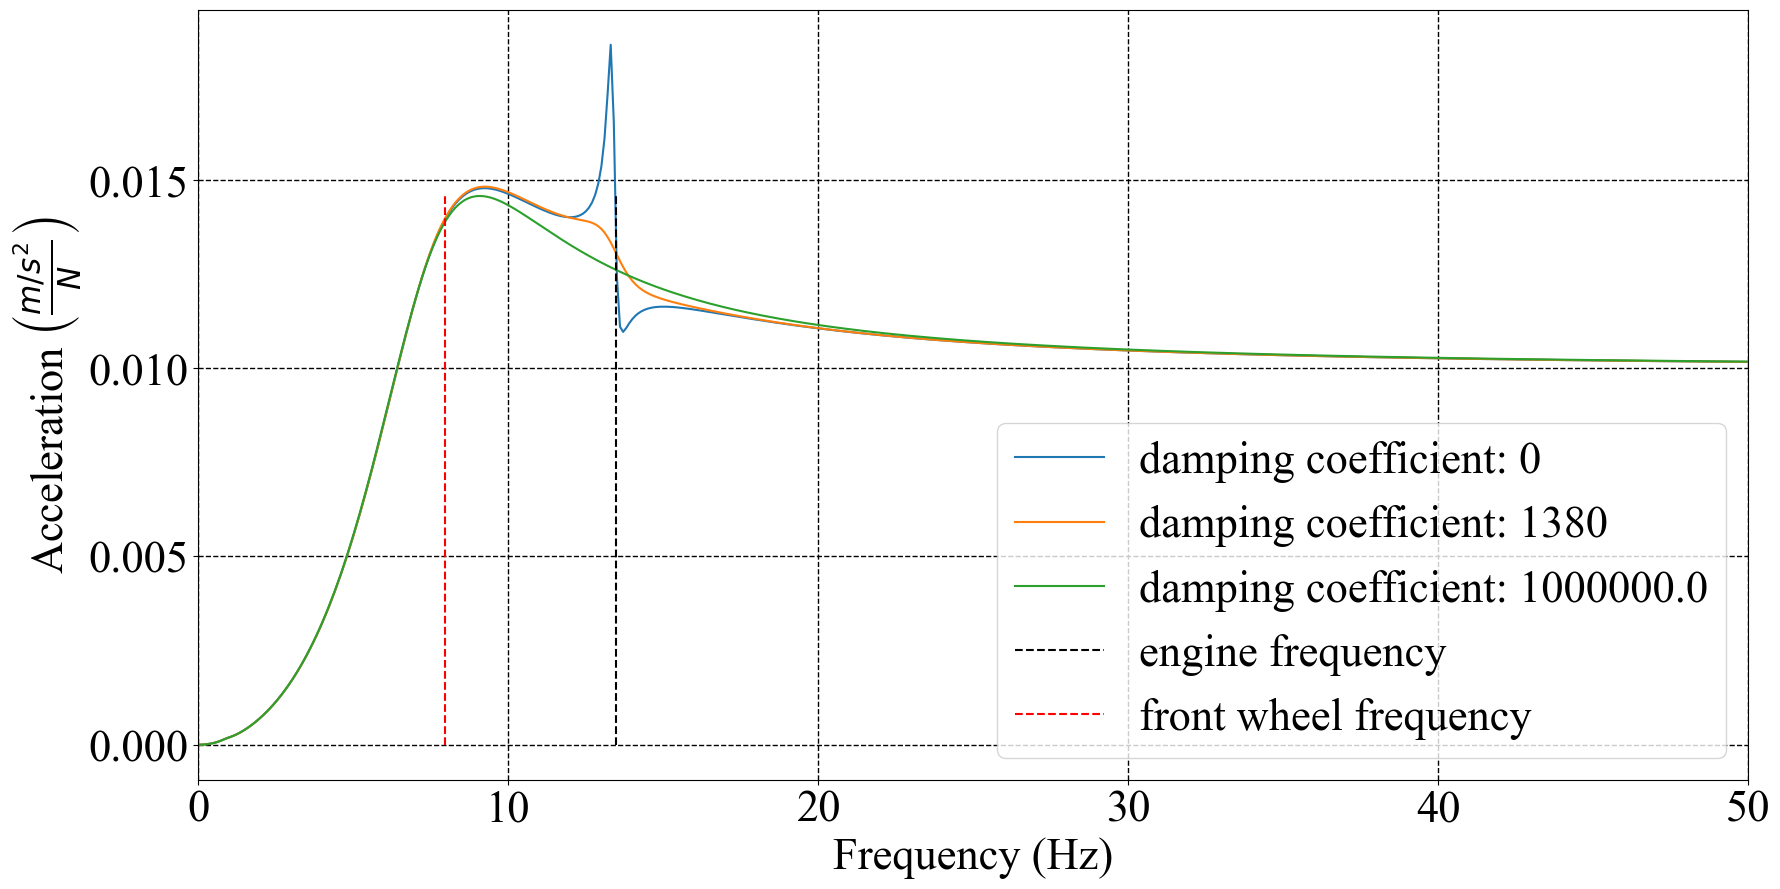

In [23]:
# define frequency vector
f = crange(0,500,0.1)
w = 2*np.pi*f
s = 1j*w
Cm_ = [0,1380,1e6]
fig,axs = plt.subplots(figsize=(20,10))
for Cm_i in Cm_:
    # change damping
    veh_inputs.Cm= Cm_i
    K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
    # define empty vector to store frf
    frf_engine_front_wheel = np.zeros(len(f))
    frf_engine_rear_wheel = np.zeros(len(f))
    for idx,s_ in enumerate(s):
        # compute transfer function
        vehicle_tf = np.linalg.inv(K_mat+C_mat*s_+M_mat*s_**2)
        
        # store frf
        frf_engine_front_wheel[idx] = np.abs(vehicle_tf[2,2]*s_**2)
        frf_engine_rear_wheel[idx] = np.abs(vehicle_tf[3,3]*s_**2)
    sns.lineplot(x=f,y=frf_engine_front_wheel,ax=axs,label=f'damping coefficient: {Cm_i}')
axs.set_xlim([0,50])
axs.vlines([fn[0]],ymin=0,ymax=frf_engine_front_wheel.max(),color='k',ls='--',label='engine frequency')
axs.vlines([fn[-1]],ymin=0,ymax=frf_engine_front_wheel.max(),color='r',ls='--',label='front wheel frequency')
axs.legend();axs.set_xlabel('Frequency (Hz)'); axs.set_ylabel(r'Acceleration $\left( \frac{m/s^2}{N} \right)$')

# Transfer function of unsprung mass between vehicle with and without engine mount

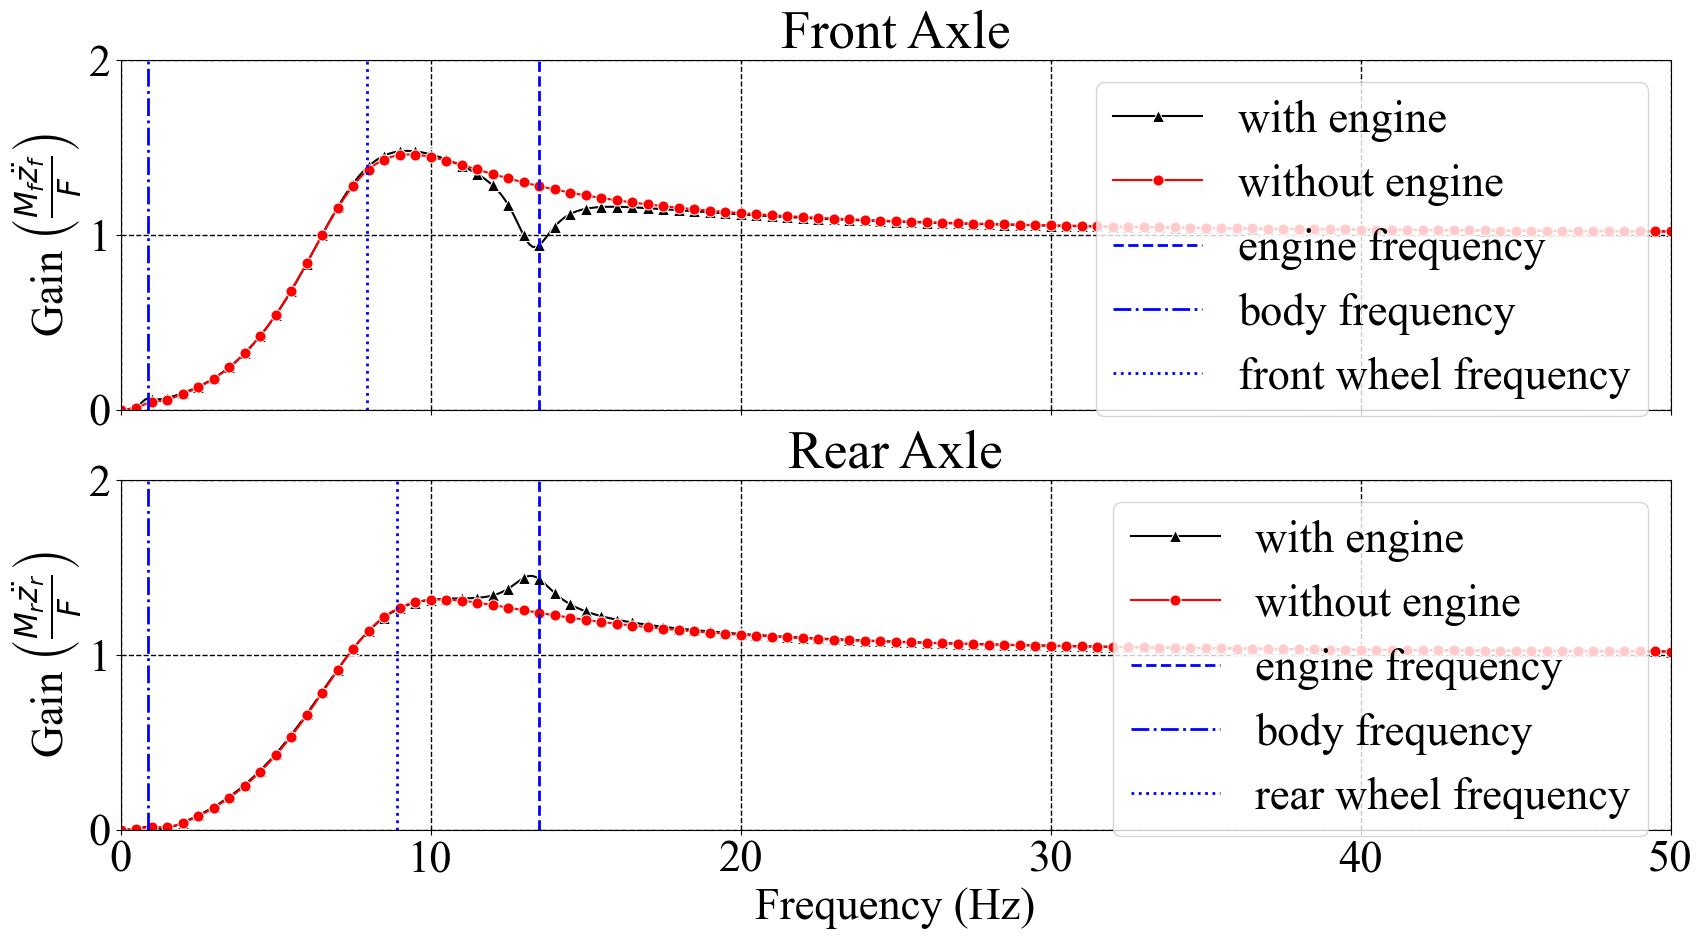

In [48]:
# define frequency vector
f = crange(0,500,0.1)
w = 2*np.pi*f
s = 1j*w
fig,axs = plt.subplots(2,1,figsize=(20,10),sharex=True)

# keep engine effects
veh_inputs.Cm = 1380 
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_front_with_engine = np.zeros(len(f))
frf_engine_rear_with_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat+C_mat*s_+M_mat*s_**2)
    
    # store frf
    frf_engine_front_with_engine[idx] = np.abs(veh_inputs.Mf*np.sum(vehicle_tf[2,:])*s_**2)
    frf_engine_rear_with_engine[idx] = np.abs(veh_inputs.Mr*np.sum(vehicle_tf[3,:])*s_**2)

sns.lineplot(x=f,y=frf_engine_front_with_engine,ax=axs[0],label=f'with engine',ls='-',marker='^',markersize=8,markevery=5,color='k')

sns.lineplot(x=f,y=frf_engine_rear_with_engine,ax=axs[1],label=f'with engine',ls='-',marker='^',markersize=8,markevery=5,color='k')

# remove engine effects
veh_inputs.Cm = 0
veh_inputs.Km = 0
veh_inputs.Me = 0 
veh_inputs.Mb = 1323 + 204
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_front_no_engine = np.zeros(len(f))
frf_engine_rear_no_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat[0:4,0:4]+C_mat[0:4,0:4]*s_+M_mat[0:4,0:4]*s_**2)
    
    # store frf
    frf_engine_front_no_engine[idx] = np.abs(veh_inputs.Mf*np.sum(vehicle_tf[2,:])*s_**2)
    frf_engine_rear_no_engine[idx] = np.abs(veh_inputs.Mr*np.sum(vehicle_tf[3,:])*s_**2)
sns.lineplot(x=f,y=frf_engine_front_no_engine,ax=axs[0],ls='-',marker='o',markersize=8,label=f'without engine',markevery=5,color='red')
axs[0].set_xlim([0,50]);axs[0].set_ylim([0,2])
axs[0].vlines([fn[0]],ymin=0,ymax=2,color='b',ls='--',lw=2,label='engine frequency')
axs[0].vlines([fn[1]],ymin=0,ymax=2,color='b',ls='-.',lw=2,label='body frequency')
axs[0].vlines([fn[-1]],ymin=0,ymax=2,color='b',ls=':',lw=2,label='front wheel frequency')
axs[0].set_xlabel('Frequency (Hz)'); axs[0].set_ylabel(r'Gain $\left( \frac{M_f\ddot{z_f}}{F} \right)$')
axs[0].legend(loc='upper right');axs[0].set_title('Front Axle')

sns.lineplot(x=f,y=frf_engine_rear_no_engine,ax=axs[1],label=f'without engine',ls='-',marker='o',markersize=8,markevery=5,color='red')
axs[1].set_xlim([0,50]);axs[1].set_ylim([0,2])
axs[1].vlines([fn[0]],ymin=0,ymax=2,color='b',ls='--',lw=2,label='engine frequency')
axs[1].vlines([fn[1]],ymin=0,ymax=2,color='b',ls='-.',lw=2,label='body frequency')
axs[1].vlines([fn[-2]],ymin=0,ymax=2,color='b',ls=':',lw=2,label='rear wheel frequency')
axs[1].set_xlabel('Frequency (Hz)'); axs[1].set_ylabel(r'Gain $\left( \frac{M_r\ddot{z_r}}{F} \right)$')
axs[1].legend(loc='upper right');axs[1].set_title('Rear Axle')

fig.savefig('../results/tf_rev_2.svg')

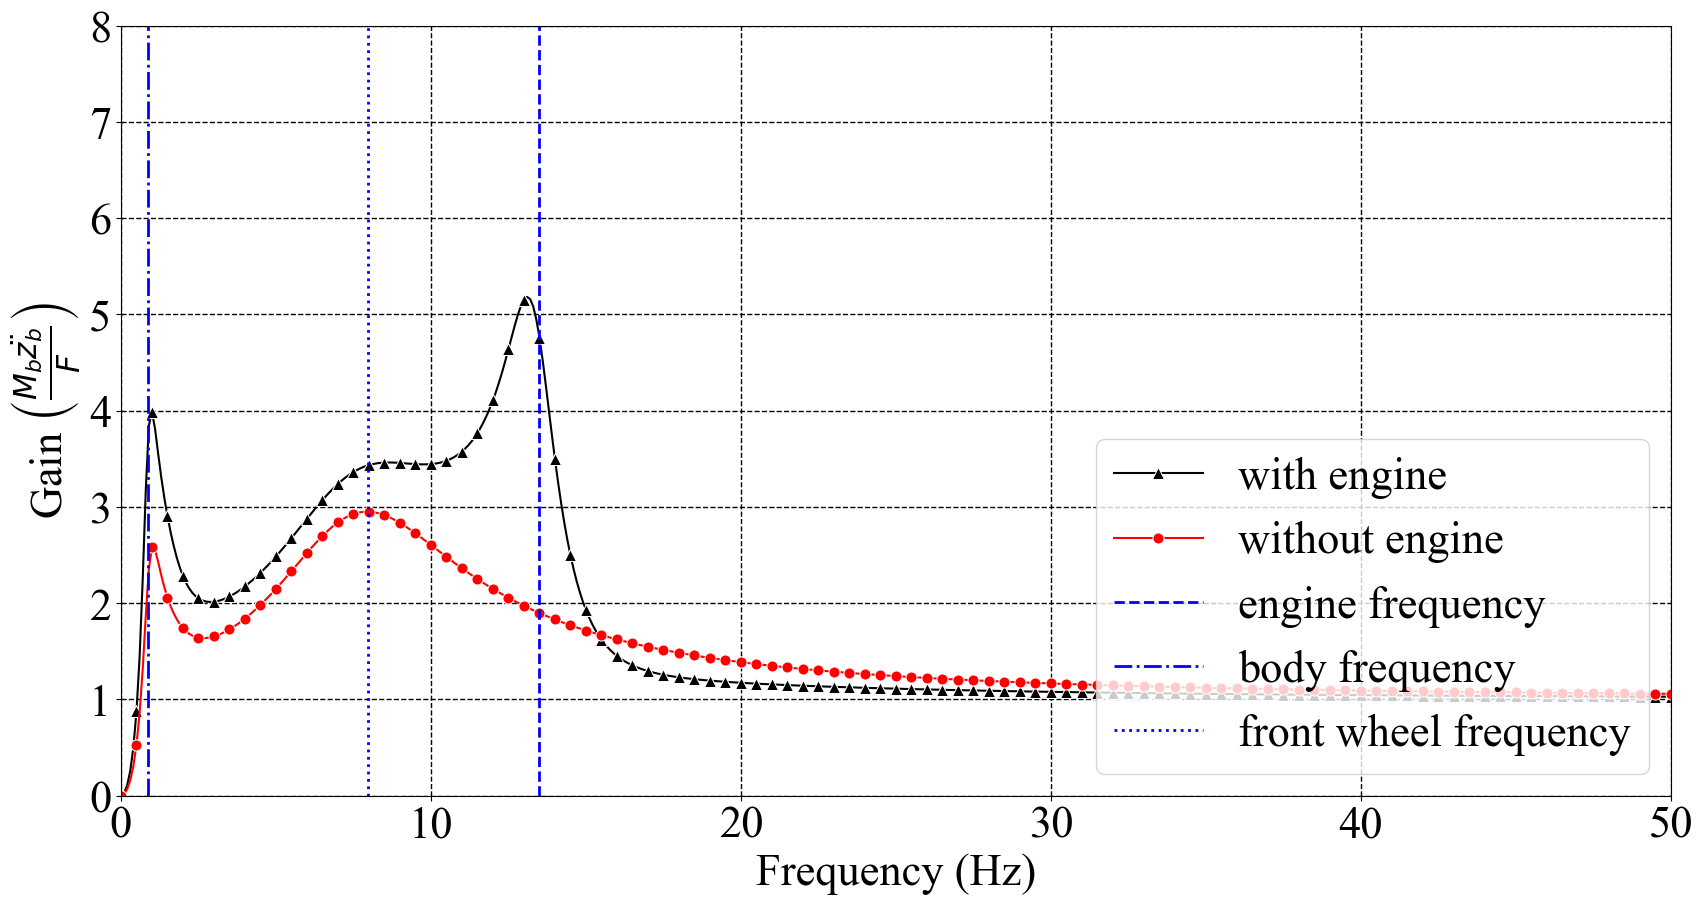

In [25]:
# define frequency vector
f = crange(0,500,0.1)
w = 2*np.pi*f
s = 1j*w
fig,axs = plt.subplots(figsize=(20,10),sharex=True)

# keep engine effects
veh_inputs.Cm = 1380 
veh_inputs.Km = 10.5e5 
veh_inputs.Me = 204
veh_inputs.Mb = 1323
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_body_with_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat+C_mat*s_+M_mat*s_**2)
    
    # store frf
    frf_engine_body_with_engine[idx] = np.abs(veh_inputs.Mb*np.sum(vehicle_tf[0,:])*s_**2)

sns.lineplot(x=f,y=frf_engine_body_with_engine,ax=axs,label='with engine',ls='-',marker='^',markersize=8,markevery=5,color='k')

# remove engine effects
veh_inputs.Cm = 0
veh_inputs.Km = 0
veh_inputs.Me = 0 
veh_inputs.Mb = 1323 + 204
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_body_no_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat[0:4,0:4]+C_mat[0:4,0:4]*s_+M_mat[0:4,0:4]*s_**2)
    
    # store frf
    frf_engine_body_no_engine[idx] = np.abs(veh_inputs.Mb*np.sum(vehicle_tf[0,:])*s_**2)
sns.lineplot(x=f,y=frf_engine_body_no_engine,ax=axs,ls='-',marker='o',markersize=8,label='without engine',markevery=5,color='red')
axs.set_xlim([0,50]);axs.set_ylim([0,8])
axs.vlines([fn[0]],ymin=0,ymax=8,color='b',ls='--',lw=2,label='engine frequency')
axs.vlines([fn[1]],ymin=0,ymax=8,color='b',ls='-.',lw=2,label='body frequency')
axs.vlines([fn[-1]],ymin=0,ymax=8,color='b',ls=':',lw=2,label='front wheel frequency')
axs.legend(loc='lower right');axs.set_xlabel('Frequency (Hz)'); axs.set_ylabel(r'Gain $\left( \frac{M_b\ddot{z_b}}{F} \right)$')
fig.savefig('../results/tf_body_rev_2.svg')

# Run engine simulation
## Input engine force

<AxesSubplot: >

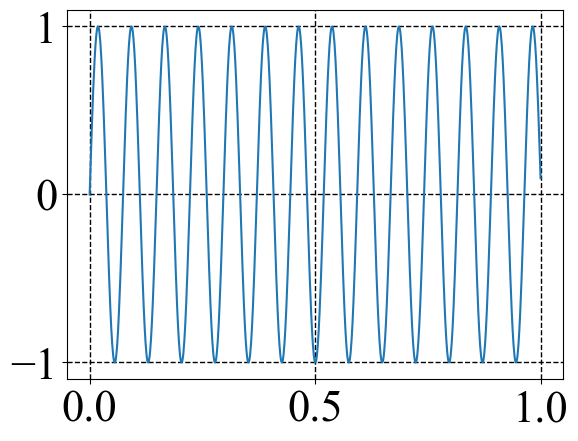

In [44]:
veh_inputs.Cm = 5000 
veh_inputs.Km = 10.5e5
veh_inputs.Me = 204 
veh_inputs.Mb = 1323 + 204
veh_ss = get_ss(veh_inputs)
t = crange(0,1,0.001)
A_inp = 1 # acceleration amplitude
P_e = A_inp*np.sin(2*np.pi*(fn[0])*t)
sns.lineplot(x=t,y=P_e)

## Scipy lsim

In [45]:
t,y,x = signal.lsim(veh_ss,P_e,t)
y.shape

(1001, 10)

# Calculate PSD

In [46]:
f,PSD = get_psd_welch(y,0.1,1000)

(0.0, 50.0)

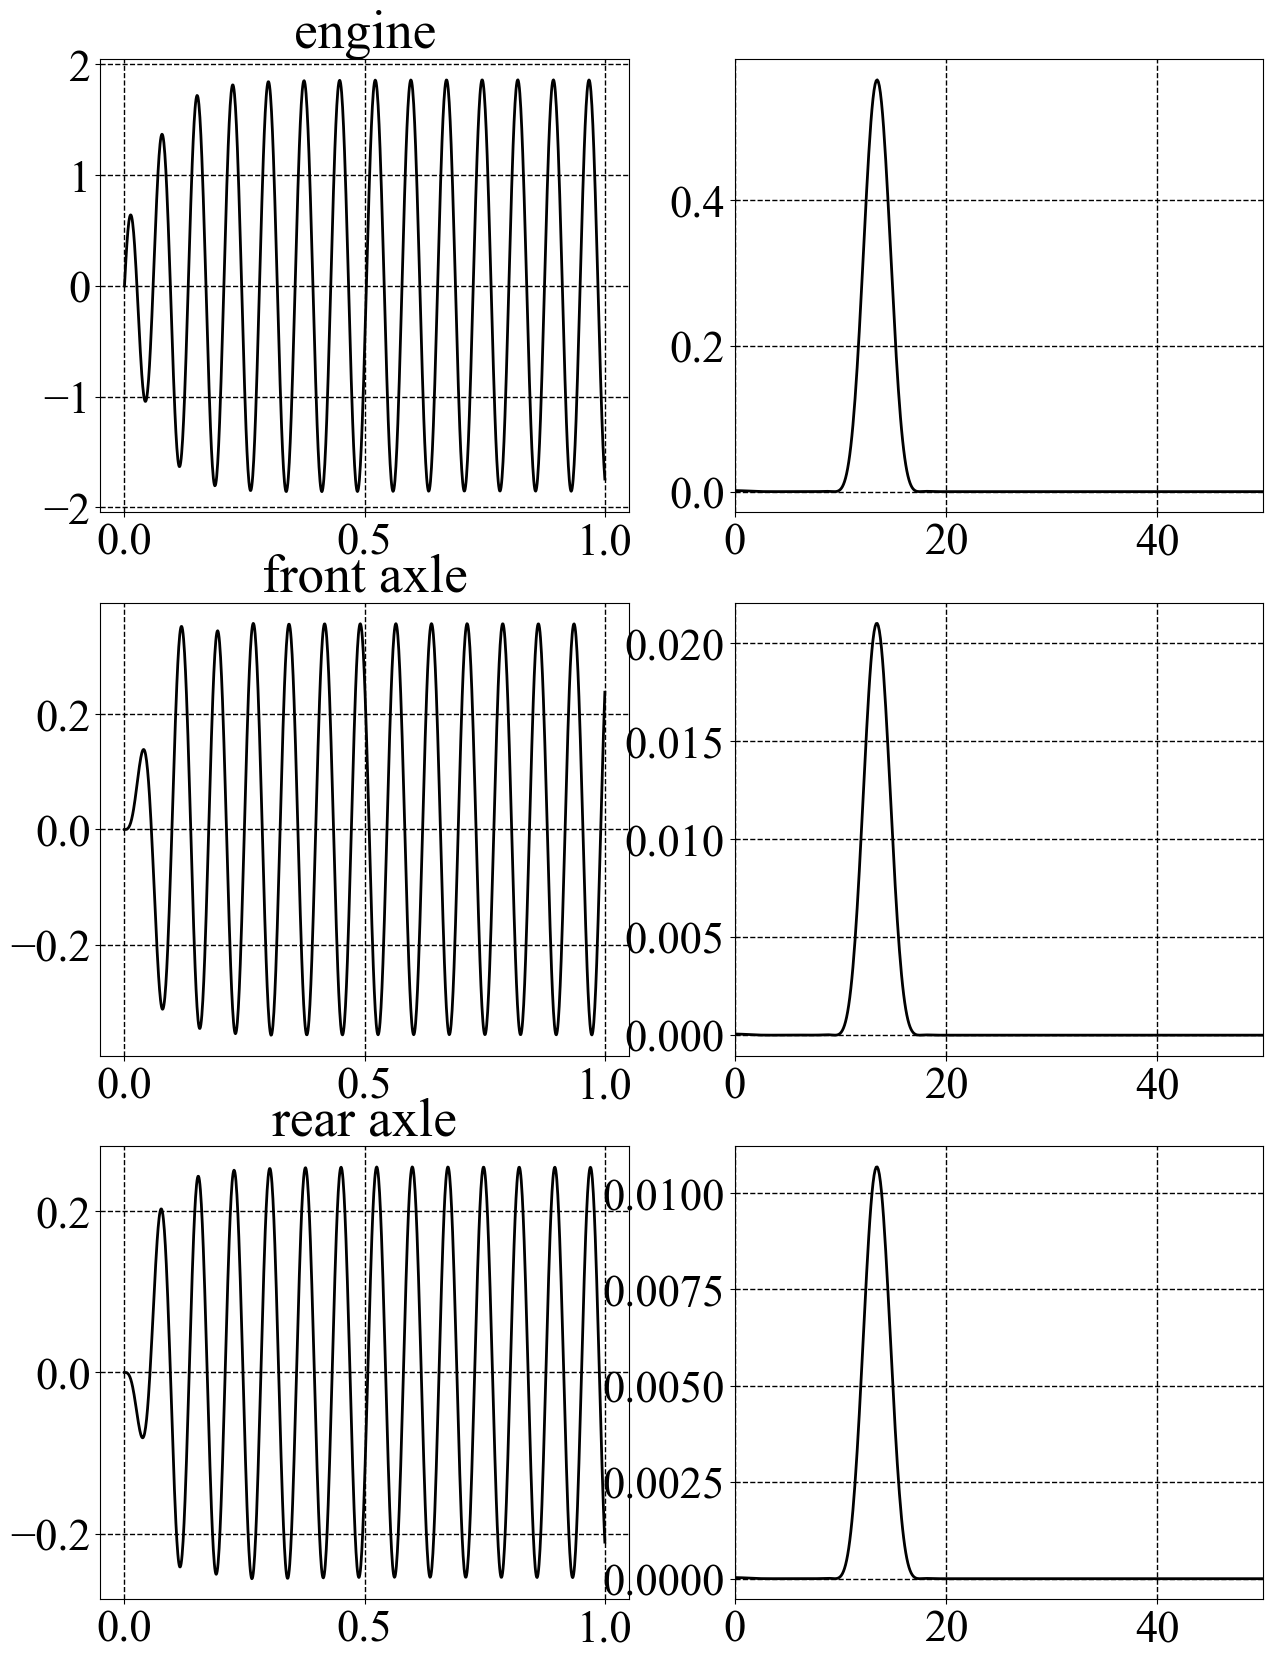

In [47]:
fig,axs = plt.subplots(3,2,figsize=(15,20))
sns.lineplot(x=t,y=y[:,9],color='k',lw=2,ax=axs[0,0]);axs[0,0].set_title('engine')
sns.lineplot(x=t,y=y[:,7],color='k',lw=2,ax=axs[1,0]);axs[1,0].set_title('front axle')
sns.lineplot(x=t,y=y[:,8],color='k',lw=2,ax=axs[2,0]);axs[2,0].set_title('rear axle')

sns.lineplot(x=f,y=PSD[:,9],color='k',lw=2,ax=axs[0,1]);axs[0,1].set_xlim([0,50])
sns.lineplot(x=f,y=PSD[:,7],color='k',lw=2,ax=axs[1,1]);axs[1,1].set_xlim([0,50])
sns.lineplot(x=f,y=PSD[:,8],color='k',lw=2,ax=axs[2,1]);axs[2,1].set_xlim([0,50])

In [29]:
tf = get_tf(veh_inputs)

In [30]:
dir(tf)

['__add__',
 '__array_priority__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_common_den',
 '_copy_names',
 '_dcgain',
 '_find_signal',
 '_generic_name_check',
 '_get_inputs',
 '_get_outputs',
 '_idCounter',
 '_isstatic',
 '_name_or_default',
 '_repr_latex_',
 '_set_inputs',
 '_set_outputs',
 '_truncatecoeff',
 'copy',
 'damp',
 'dcgain',
 'den',
 'dt',
 'feedback',
 'find_input',
 'find_output',
 'find_state',
 'freqresp',
 'frequency_response',
 'horner',
 'input_index',
 'input_labels',
 'inputs',
 'isctime',
 'i

In [31]:
tf

TransferFunction([[array([-2.08005047e-17,  3.27439424e+00,  9.95238409e+02,  9.01996505e+04,
        6.36850330e+06,  2.41018745e+08,  7.23110167e+09,  8.33892998e+10,
        6.15743775e+11])], [array([-3.57973548e-18,  5.38000000e+00,  1.58430342e+03,  1.35289582e+05,
        9.71518405e+06,  3.29460040e+08,  9.97838941e+09,  5.16662328e+10,
        3.81501719e+11])], [array([-7.31314366e-18,  5.50216125e-13,  3.17214598e+02,  8.61146825e+04,
        5.25492771e+06,  2.60293643e+08,  3.64213682e+09,  2.93211321e+10,
        1.23148755e+11])], [array([-5.61312373e-18,  4.18487237e-13, -2.36640502e+02, -6.00052702e+04,
       -2.82785400e+06, -1.44215483e+08, -1.06488226e+09, -3.41415405e-04,
       -3.05175781e-05])], [array([1.00000000e+00, 1.05567128e+02, 1.07433221e+04, 5.55001915e+05,
       2.74379637e+07, 7.37148374e+08, 1.93863711e+10, 1.45002772e+11,
       1.05204222e+12])], [array([3.27439424e+00, 9.95238409e+02, 9.01996505e+04, 6.36850330e+06,
       2.41018745e+08, 7.2311

In [32]:
tf.damp()[0]/(2*np.pi)

c:\Users\oabuode\Desktop\Clemson PhD\Thesis\Abaqus\Input file tests\APPVMD\cenvs\lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


array([13.2421306 , 13.2421306 ,  8.24966887,  8.24966887,  7.81259835,
        7.81259835,  1.63564559,  1.63564559,  0.84301022,  0.84301022])

In [33]:
fn_tf,fn_idx=np.unique(tf.damp()[0]/(2*np.pi),return_index=True)
fn_tf

array([ 0.84301022,  1.63564559,  7.81259835,  8.24966887, 13.2421306 ])

In [34]:
tf.damp()[1][fn_idx]/(2*np.pi)*100

array([4.2864474 , 8.12878116, 5.94931998, 6.88667402, 3.36370397])

In [35]:
mag,phase,omega = control.freqresp(tf,w)

(0.0, 50.0)

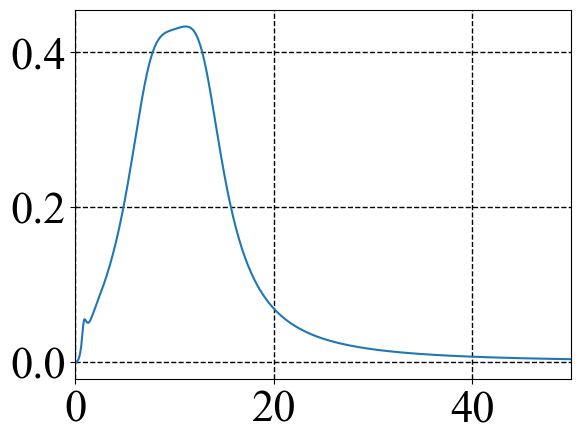

In [36]:
fig,axs = plt.subplots()
sns.lineplot(x=omega/(2*np.pi),y=np.reshape(mag[7,:,:],len(omega)),ax=axs)
axs.set_xlim([0,50])